In [1]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import numpy as np
from pandas import unique

from utils.plots import visualize_vehicle_trajectories
from utils.new_columns_fiorenzo import add_speed_direction_to_summary, pixel_meters_ratio, add_day_night_to_summary, classify_vehicle_types
from utils.plots_fiorenzo import interactive_dimension_plot_by_cat, plot_size_distribution, visualize_classification, interactive_dimension_plot_by_class, vehicle_count_over_time_histogram, average_speed_over_time_plot
from data_pipeline import process_all_sessions
from utils.loader import load_data_from_database
from utils.transformer import categorize_ids

In [2]:
final_summary = None
summary_loaded = False
print("Do you want to load saved final_summary?")
if input("Type 'y' to proceed: ").lower() == 'y':
    final_summary = pd.read_csv('final_summary.csv')
    summary_loaded = True

Do you want to load saved final_summary?


In [3]:
if not summary_loaded:
    print("Do you want to load data from the database? This may take a while.")
    if input("Type 'y' to proceed: ").lower() == 'y':
        df = load_data_from_database()
        df = df.sort_values(['date_time', 'frame_id'])
    else:
        df = pd.read_csv("raw_traffic_data.csv", parse_dates=['date_time'])
        df = df.sort_values(['date_time', 'frame_id'])

In [4]:
if not summary_loaded:
    df['session_id'] = (
        (df['frame_id'].diff() < 0)
    ).cumsum()

In [5]:
if not summary_loaded:
    final_summary = process_all_sessions(df)
    print(final_summary.head())
    print(unique(final_summary['category']))
    final_summary_viable = final_summary[final_summary['category'].isin(['Perfect', 'Partial', 'Merged'])]

In [6]:
## Filter time
final_summary['t_start'] = pd.to_datetime(final_summary['t_start'])
final_summary['t_end'] = pd.to_datetime(final_summary['t_end'])

start_date = pd.to_datetime('2025-12-01')
end_date = pd.to_datetime('2026-01-01')

final_summary = final_summary[(final_summary['t_start'] >= start_date) & (final_summary['t_start'] < end_date)]
print(f"Filtered data from {start_date.date()} to {end_date.date()}")
print(f"Remaining records: {len(final_summary)}")
print(final_summary)

Filtered data from 2025-12-01 to 2026-01-01
Remaining records: 489601
        session_id         vehicle_id  y_start  y_end      w_mean      w_std  \
0                2  [np.int64(19309)]      273    273  101.000000        NaN   
1                2  [np.int64(19310)]      273    273   99.000000        NaN   
2                2            [19311]      276    276   73.000000        NaN   
3                2            [19312]      272    272   97.600000  18.662797   
4                2            [19313]      275    275   68.000000        NaN   
...            ...                ...      ...    ...         ...        ...   
489596          15            [93092]        0      0   41.000000        NaN   
489597          15            [93093]      279    274   92.384615   9.853413   
489598          15            [93094]      275    275   73.000000        NaN   
489599          15            [93095]      278    273   76.000000  21.213203   
489600          15            [93096]       38    

In [7]:
## Duration, Speed and Direction
if not summary_loaded:
    final_summary['duration'] = (final_summary['t_end'] - final_summary['t_start']).dt.total_seconds()

    final_summary = add_speed_direction_to_summary(final_summary)

    print(final_summary.head())

In [8]:
## Create columns size_mean and h/w_mean ratio
if not summary_loaded:
    final_summary['size_mean'] = final_summary['w_mean'] * final_summary['h_mean']
    final_summary['h_w_mean_ratio'] = final_summary['h_mean'] / final_summary['w_mean']
    print(final_summary.head())

In [9]:
## Mean height, width and size in meters
if not summary_loaded:
    final_summary['h_mean_meters'] = final_summary['h_mean'] / pixel_meters_ratio
    final_summary['w_mean_meters'] = final_summary['w_mean'] / pixel_meters_ratio
    final_summary['size_mean_meters'] = final_summary['size_mean'] / pixel_meters_ratio
    print(final_summary)

In [10]:
## Day/Night difference
if not summary_loaded:
    final_summary = add_day_night_to_summary(final_summary)
    print(final_summary)

In [11]:
## Save final_summary
if not summary_loaded:
    final_summary.to_csv('final_summary.csv', index=False)

In [12]:
## Apply vehicle classification
# Classify vehicles using automatic data-driven thresholds
final_summary = classify_vehicle_types(final_summary, verbose=True)

'''
# Optional: Use custom thresholds if you want to fine-tune the classification
# Uncomment and adjust values as needed:
# final_summary_with_class = classify_vehicle_types(
#     final_summary_viable,
#     size_threshold=7500,      # Threshold for area (w_mean * h_mean)
#     width_threshold=70,        # Threshold for width
#     height_threshold=140,      # Threshold for height
#     verbose=True
# )
'''
# Show sample results
print("\n" + "="*70)
print("SAMPLE CLASSIFIED VEHICLES")
print("="*70)
print("\nFirst 10 vehicles:")
print(final_summary[['vehicle_id', 'w_mean', 'h_mean', 'size_mean', 'h_w_mean_ratio', 'Class']].head(10).to_string(index=False))

print("\n" + "="*70)
print("CLASS DISTRIBUTION BY TRACK CATEGORY")
print("="*70)
crosstab = pd.crosstab(final_summary['category'],
                       final_summary['Class'],
                       margins=True, margins_name='Total')
print(crosstab)
print("\n" + "="*70)

VEHICLE CLASSIFICATION RESULTS - DAY

Vehicles classified during Day: 288752

Classification threshold used for Day:
  Height threshold:          120.00 pixels

Class distribution for Day:
  Car   : 267902 ( 92.8%)
  Truck : 20850 (  7.2%)

Duration threshold calculated from Day data:
  Mean Car duration:           0.88 seconds
  Mean Truck duration:         1.78 seconds
  Calculated threshold:        1.33 seconds (midpoint)

VEHICLE CLASSIFICATION RESULTS - NIGHT

Vehicles classified during Night: 189716

Classification thresholds used for Night (OR logic):
  Height threshold:          120.00 pixels
  Width threshold:           110.00 pixels
  Duration threshold:          1.33 seconds

Trucks classified by criterion:
  By height:               16059
  By width (not height):   31881
  By duration (not h/w):   20144

Class distribution for Night:
  Car   : 189614 ( 99.9%)
  Truck :  102 (  0.1%)

OVERALL CLASSIFICATION SUMMARY

Total vehicles classified: 489601

Overall class distributi

Total


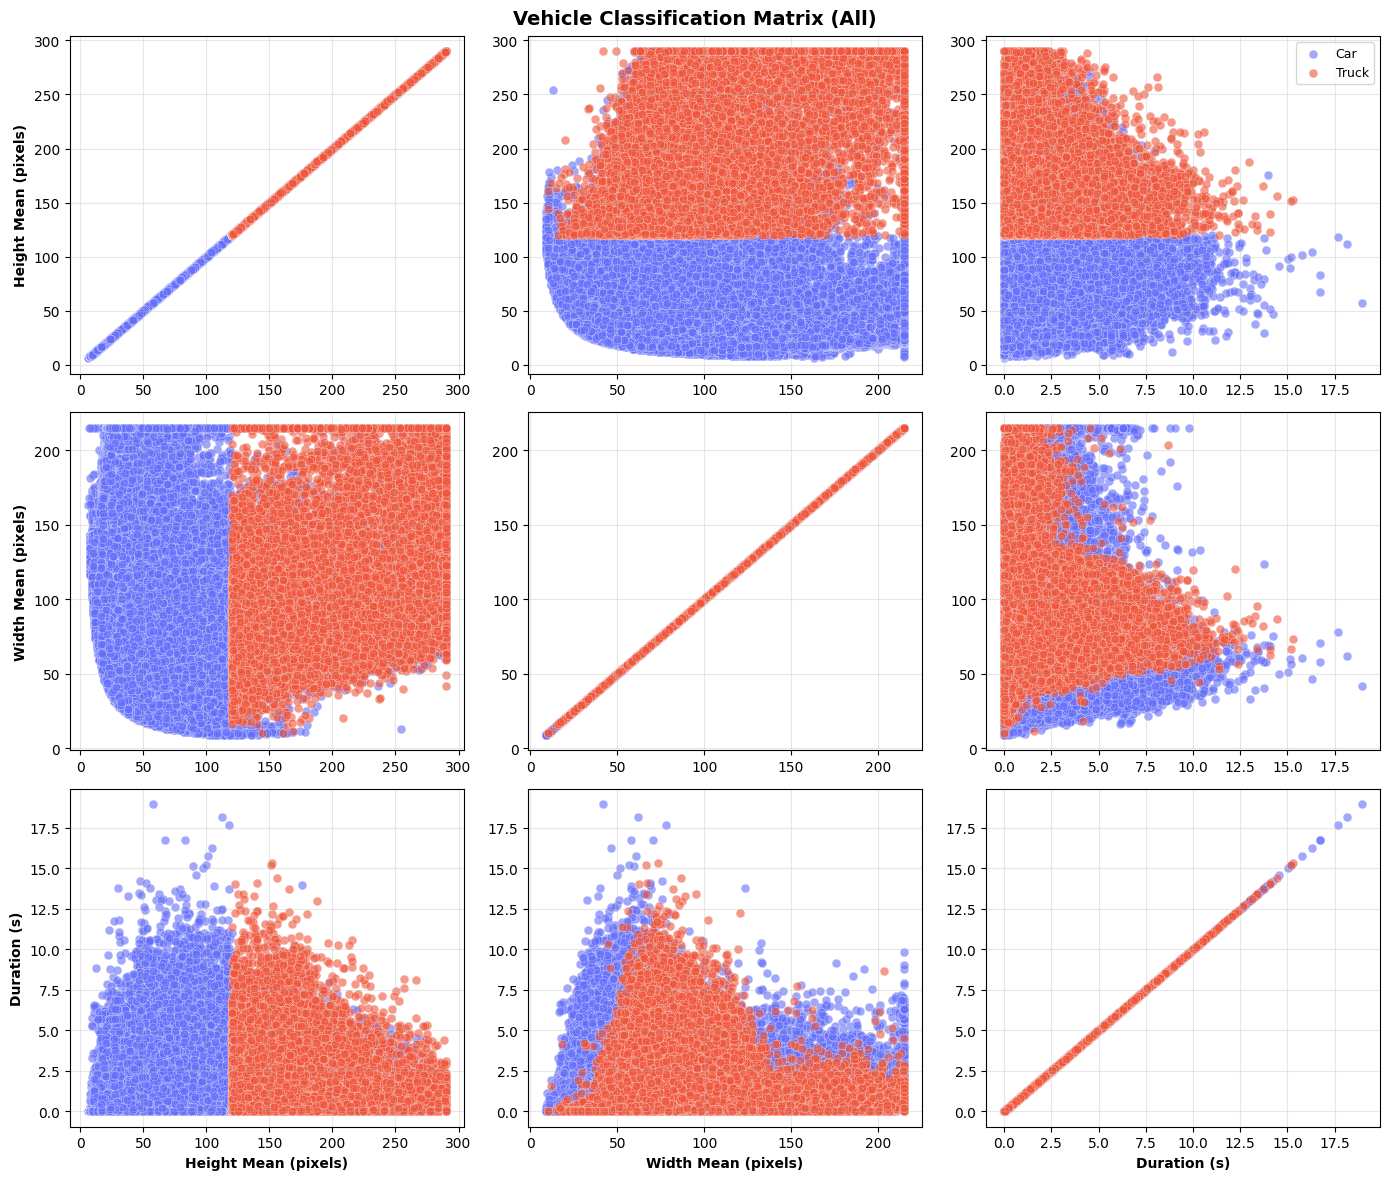


CLASSIFICATION SUMMARY (All)

Total vehicles: 489601
  Cars:   457516 (93.4%)
  Trucks: 20952 (4.3%)

Day


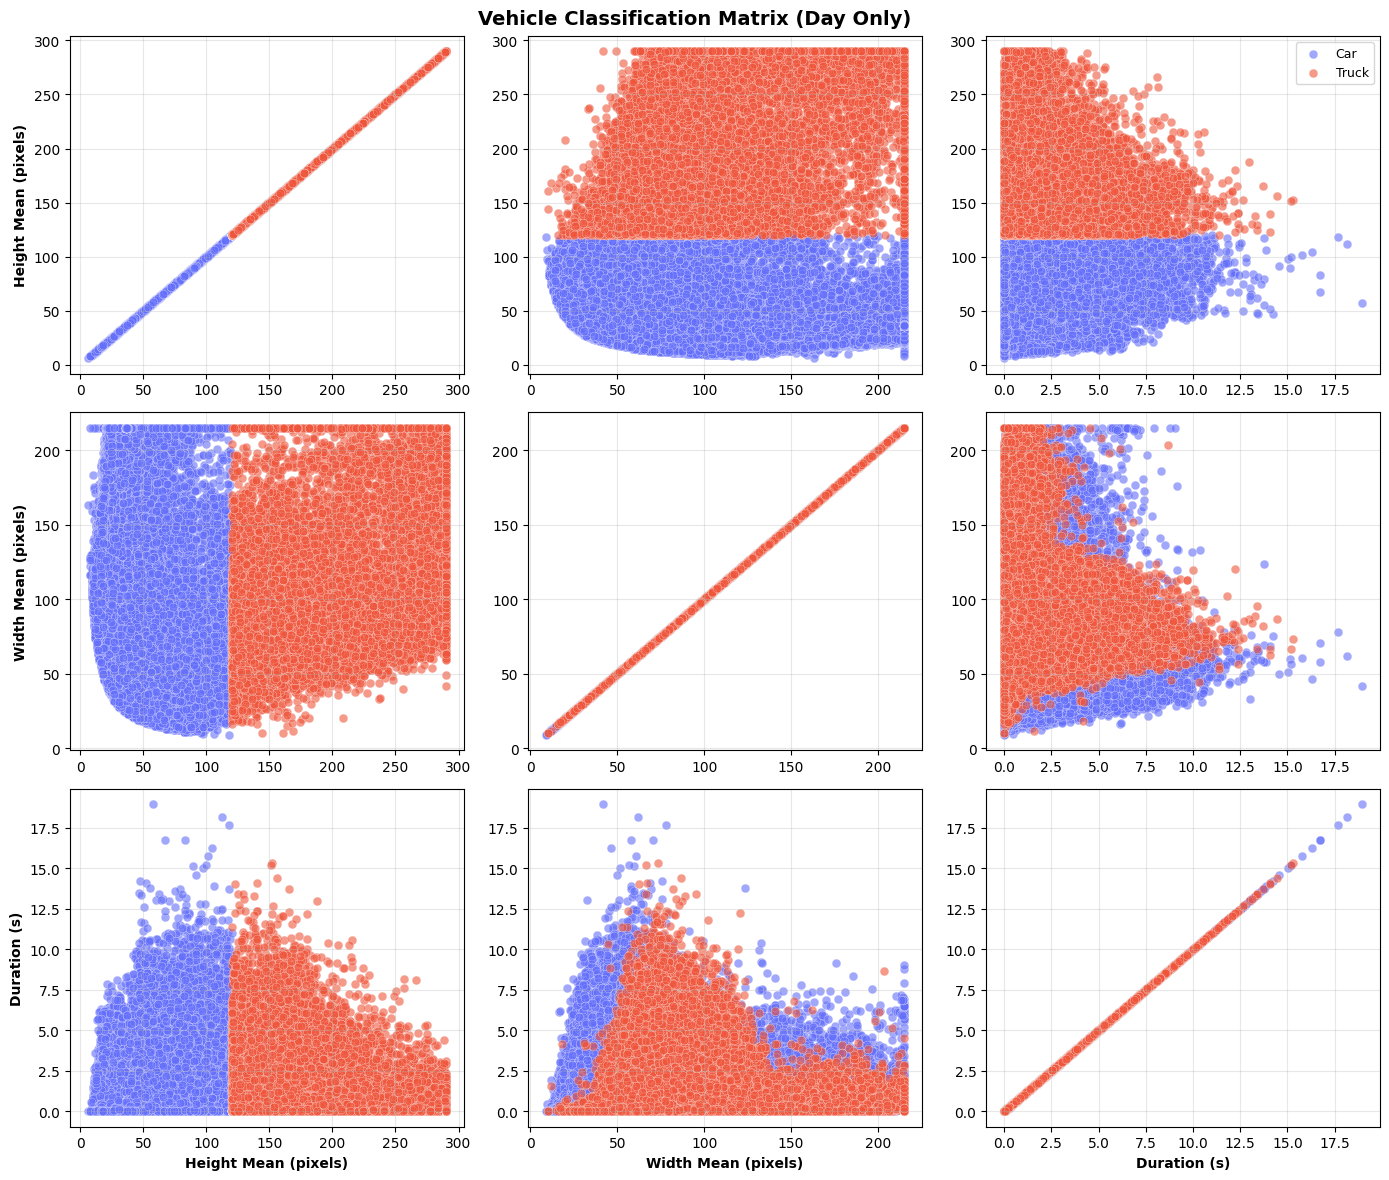


CLASSIFICATION SUMMARY (Day Only)

Total vehicles: 288752
  Cars:   267902 (92.8%)
  Trucks: 20850 (7.2%)

Night


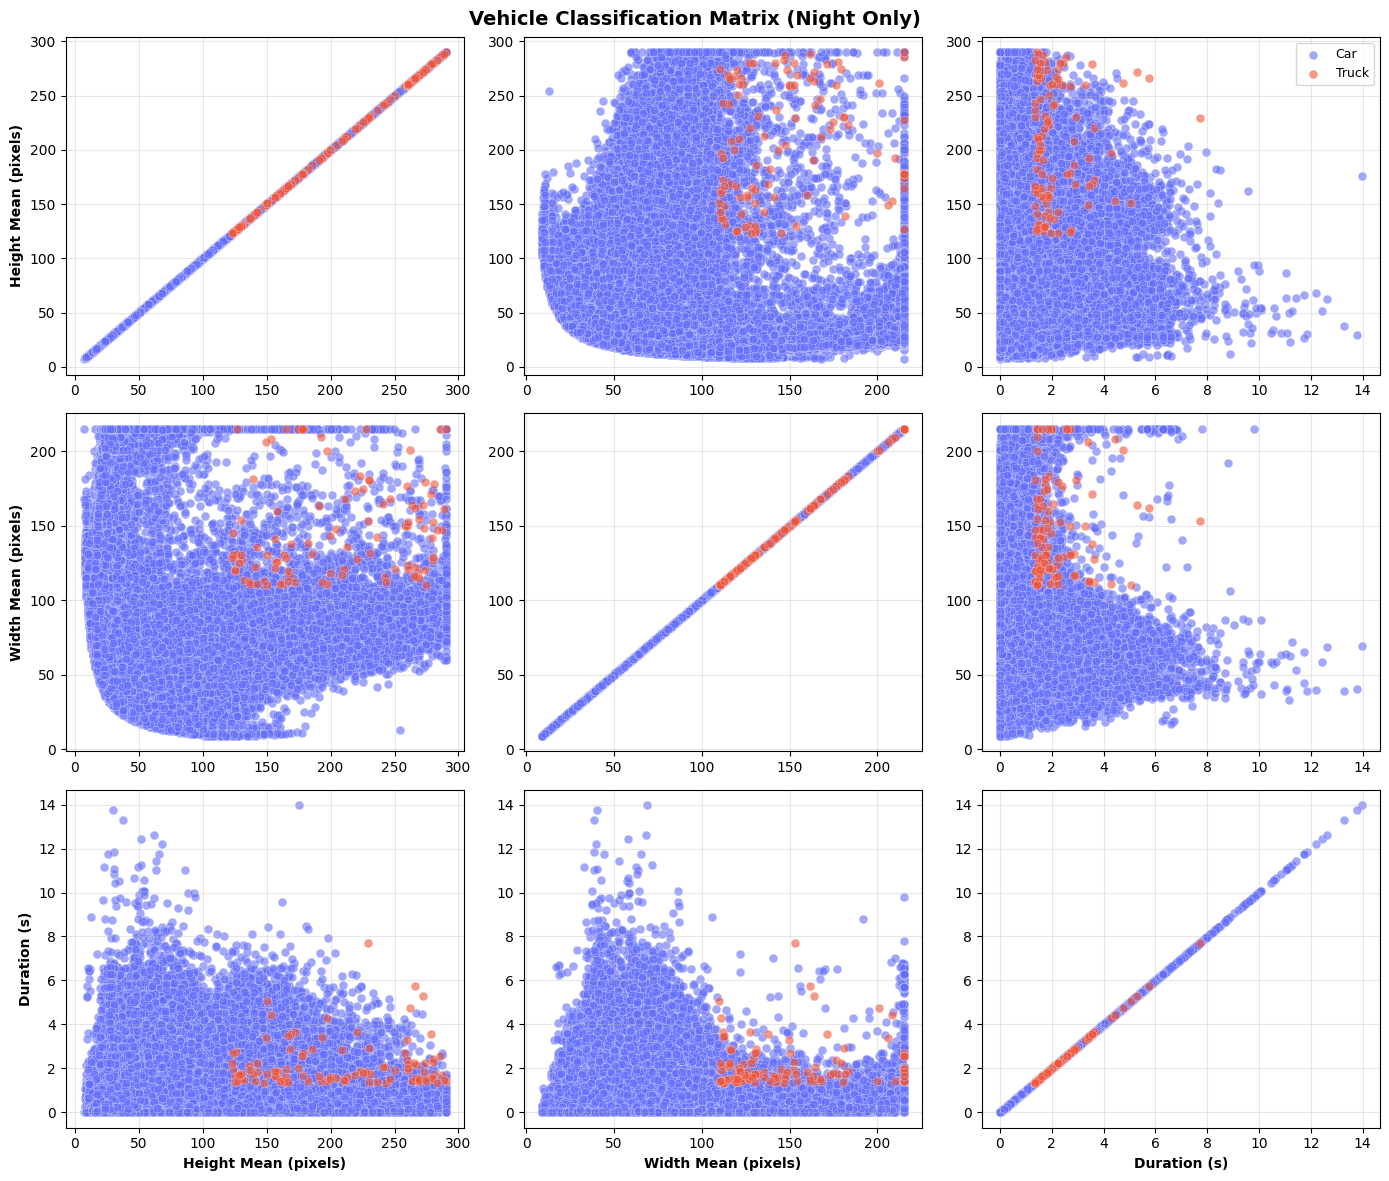


CLASSIFICATION SUMMARY (Night Only)

Total vehicles: 189716
  Cars:   189614 (99.9%)
  Trucks: 102 (0.1%)



In [13]:
## Visualize vehicle classification
print("Total")
visualize_classification(final_summary, show_plot=True)
print("Day")
visualize_classification(final_summary, show_plot=True, day_only=True)
print("Night")
visualize_classification(final_summary, show_plot=True, night_only=True)

/Users/koi/Library/Mobile Documents/com~apple~CloudDocs/Fiorenzo Luethi/Istruzione/FHNW/Secondo Semestre/cde1 1db - Vision-based Traffic Monitoring/Traffic-Challenge-Wrang/Traffic-monitoring-Challenge/utils/plots_fiorenzo.py:161: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patch = ax.axhspan(i - 0.4, i + 0.4, alpha=0.2, color='gray',
/Users/koi/Library/Mobile Documents/com~apple~CloudDocs/Fiorenzo Luethi/Istruzione/FHNW/Secondo Semestre/cde1 1db - Vision-based Traffic Monitoring/Traffic-Challenge-Wrang/Traffic-monitoring-Challenge/utils/plots_fiorenzo.py:161: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patch = ax.axhspan(i - 0.4, i + 0.4, alpha=0.2, color='gray',
/Users/koi/Library/Mobile Documents/com~apple~CloudDocs/Fiorenzo Luethi/Istruzione/FHNW/Secondo Semestre/cde1 1db - Vision-based Traffic Monitoring/Traffic-Challenge-Wrang/Traffic-monitoring-Challenge/utils/plots_fiorenzo.

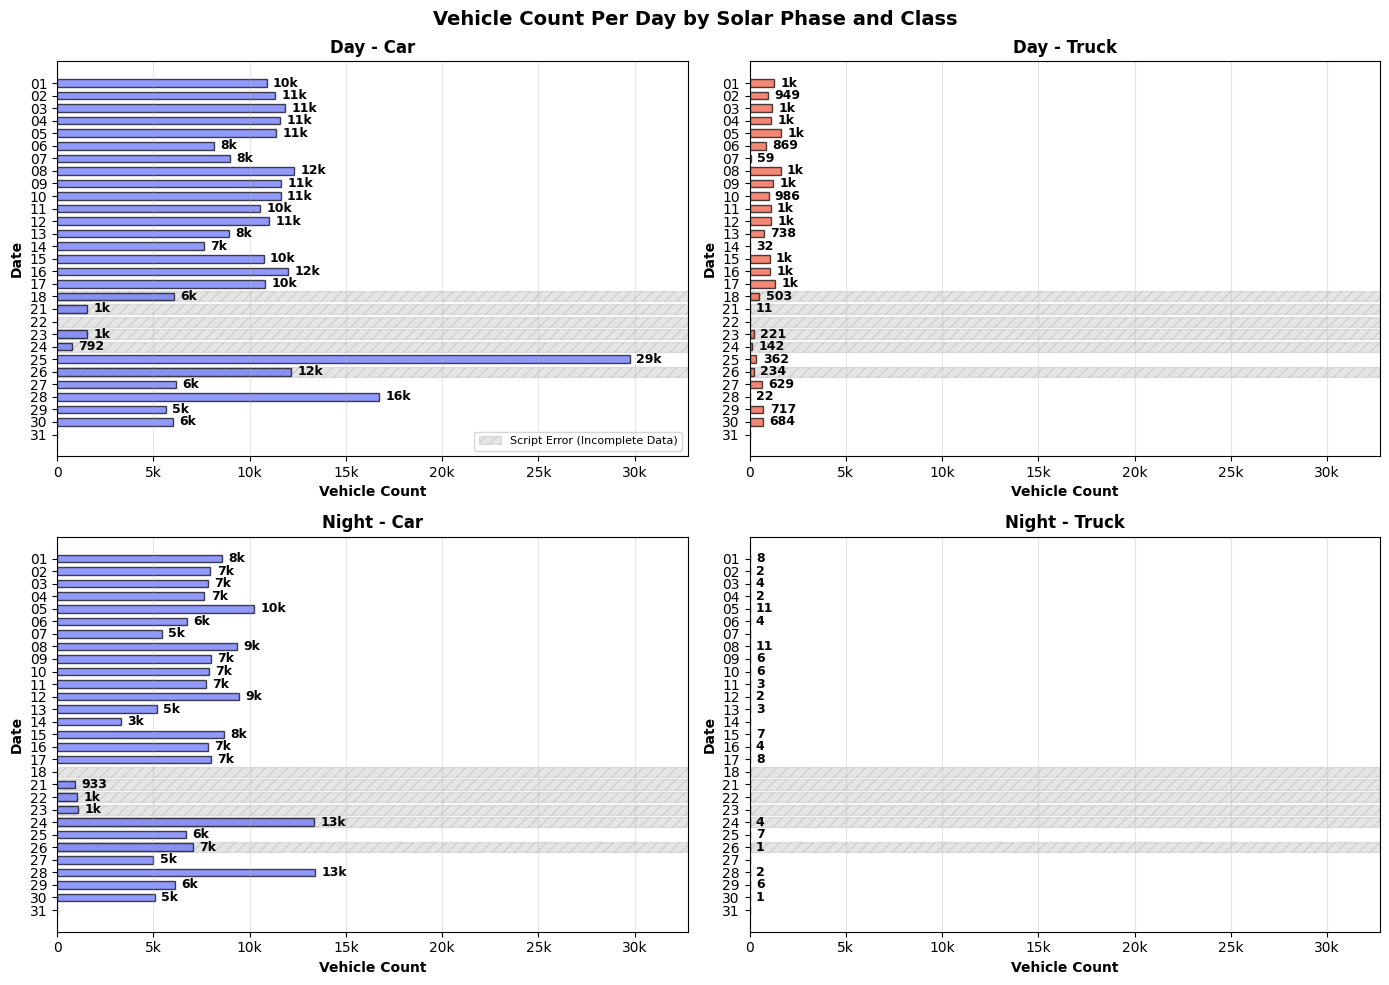

VEHICLE COUNT STATISTICS

Total vehicles: 489601

Count by Solar Phase and Class:
Class           Car  Truck
solar_phase               
Day          267902  20850
Night        189614    102

Count per day by Solar Phase and Class:
Class                     Car  Truck
date       solar_phase              
2025-12-01 Day          10884   1266
           Night         8565      8
2025-12-02 Day          11314    949
           Night         7971      2
2025-12-03 Day          11851   1169
           Night         7855      4
2025-12-04 Day          11584   1120
           Night         7658      2
2025-12-05 Day          11397   1627
           Night        10223     11
2025-12-06 Day           8148    869
           Night         6770      4
2025-12-07 Day           8996     59
           Night         5433      0
2025-12-08 Day          12326   1609
           Night         9337     11
2025-12-09 Day          11625   1243
           Night         7981      6
2025-12-10 Day          11612

In [14]:
## Distribution plot
vehicle_count_over_time_histogram(final_summary, show_plot=True)

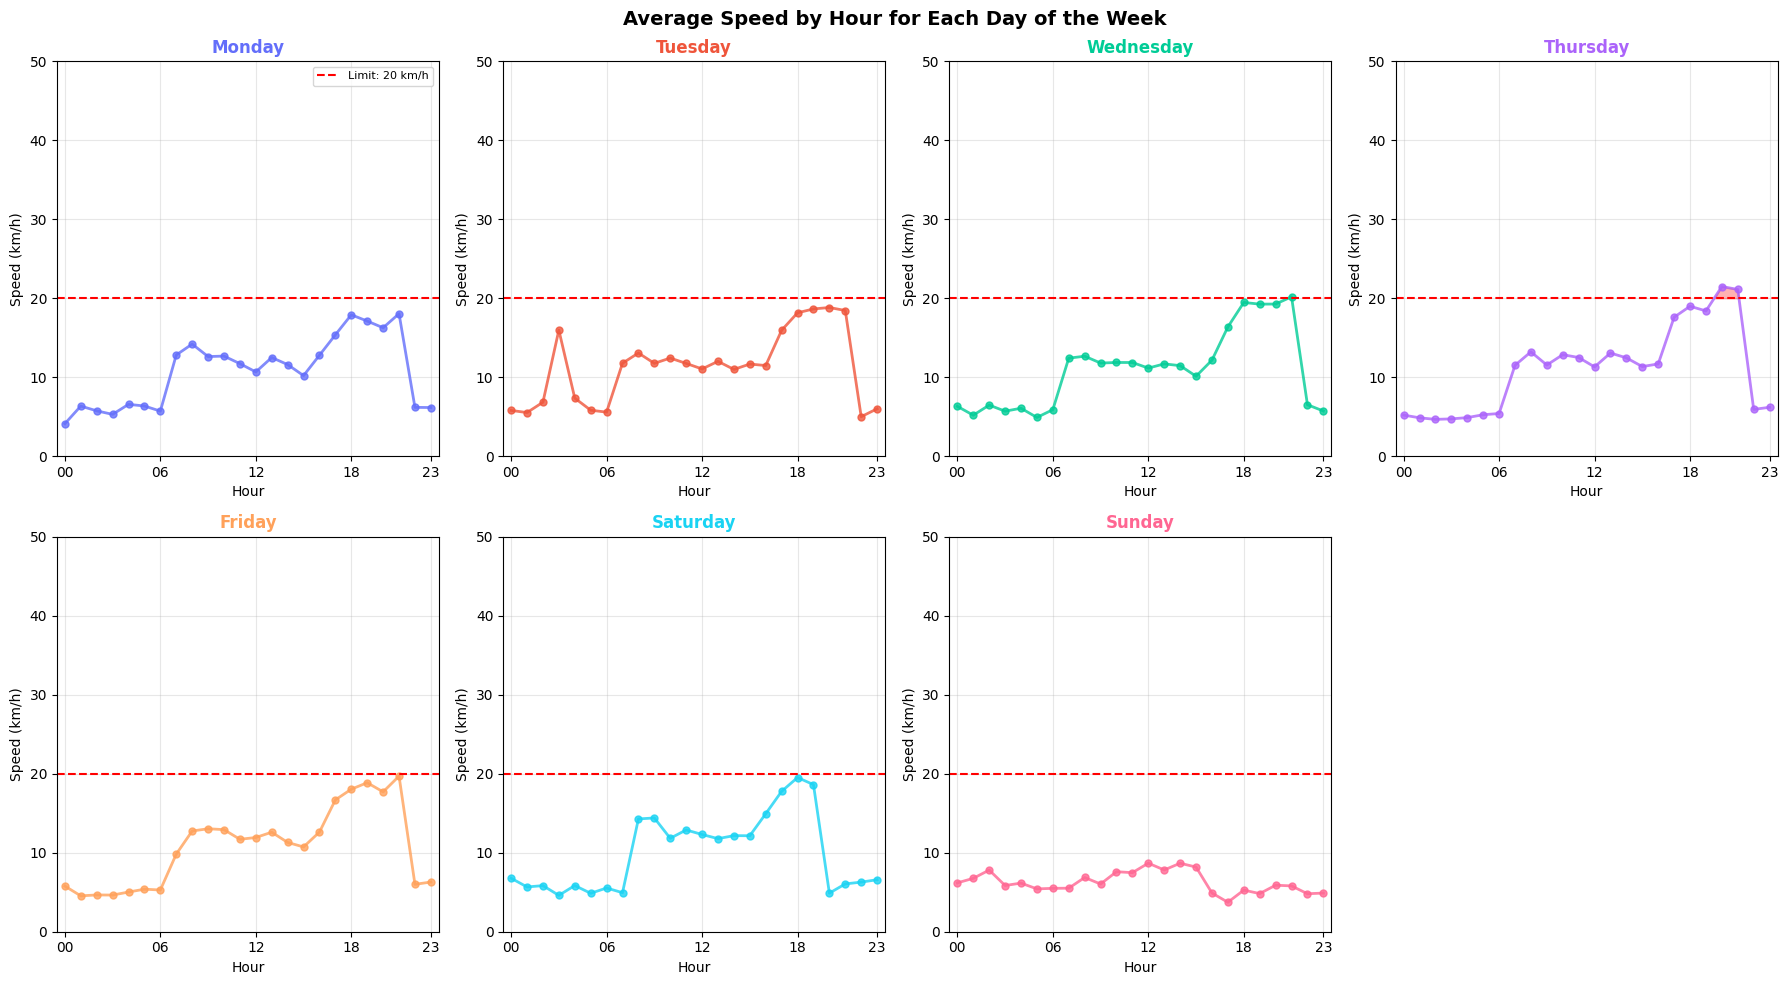

AVERAGE SPEED BY DAY OF WEEK AND HOUR (km/h)

Pivot Table (rows=hour, columns=day of week):
day_of_week  Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday
hour                                                                       
0              4.12     5.80       6.32      5.21    5.78      6.77    6.19
1              6.35     5.53       5.19      4.87    4.54      5.67    6.76
2              5.75     6.84       6.47      4.67    4.66      5.84    7.81
3              5.30    15.97       5.70      4.73    4.64      4.60    5.85
4              6.57     7.36       6.08      4.89    5.02      5.85    6.16
5              6.36     5.83       4.91      5.25    5.39      4.87    5.42
6              5.71     5.58       5.89      5.41    5.28      5.54    5.49
7             12.82    11.78      12.41     11.51    9.83      4.94    5.51
8             14.20    13.07      12.66     13.22   12.75     14.28    6.87
9             12.62    11.76      11.80     11.54   13.04     14.41    6

In [15]:
## Average speed by weekday and hour
from utils.plots_fiorenzo import average_speed_by_weekday_and_hour
average_speed_by_weekday_and_hour(final_summary, show_plot=True)

/Users/koi/Library/Mobile Documents/com~apple~CloudDocs/Fiorenzo Luethi/Istruzione/FHNW/Secondo Semestre/cde1 1db - Vision-based Traffic Monitoring/Traffic-Challenge-Wrang/Traffic-monitoring-Challenge/utils/plots_fiorenzo.py:161: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patch = ax.axhspan(i - 0.4, i + 0.4, alpha=0.2, color='gray',


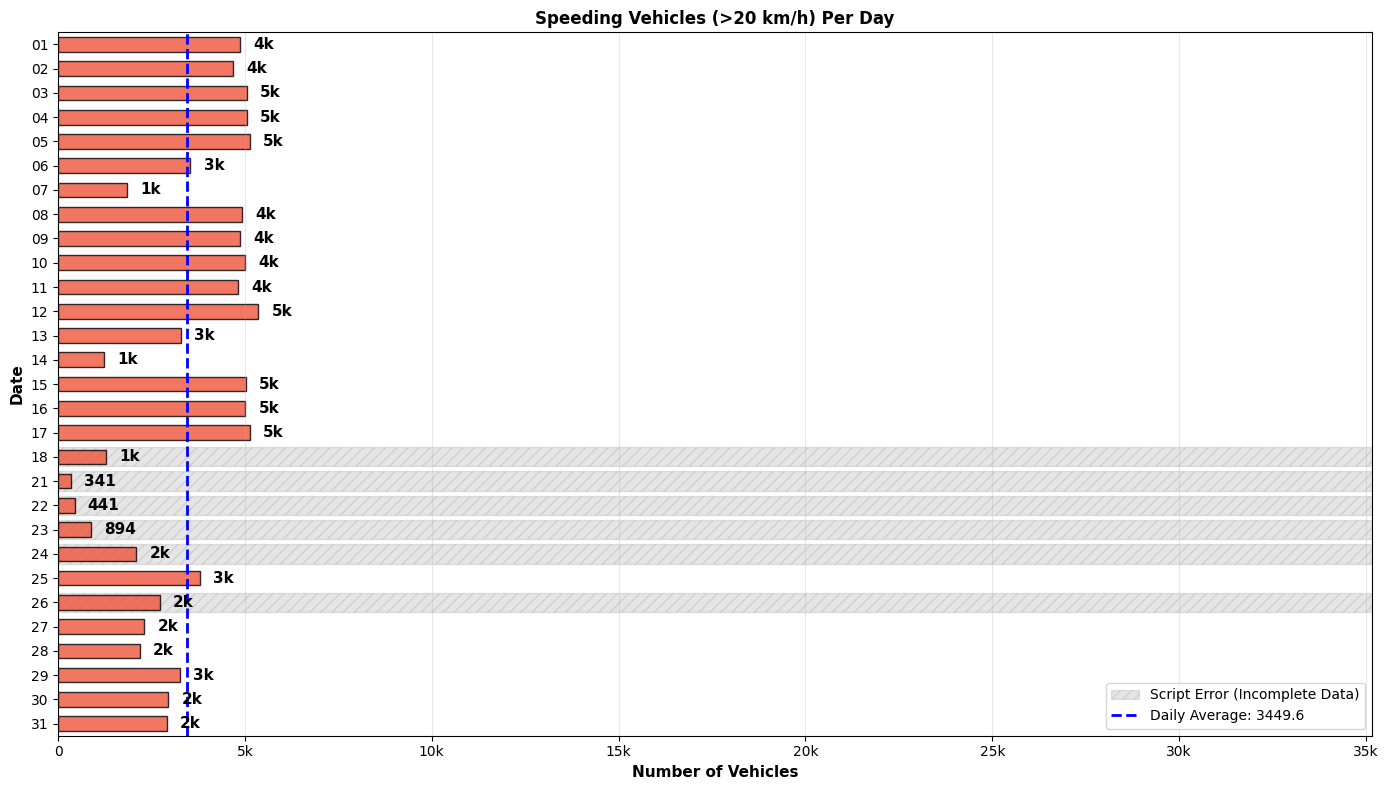

/Users/koi/Library/Mobile Documents/com~apple~CloudDocs/Fiorenzo Luethi/Istruzione/FHNW/Secondo Semestre/cde1 1db - Vision-based Traffic Monitoring/Traffic-Challenge-Wrang/Traffic-monitoring-Challenge/utils/plots_fiorenzo.py:161: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patch = ax.axhspan(i - 0.4, i + 0.4, alpha=0.2, color='gray',


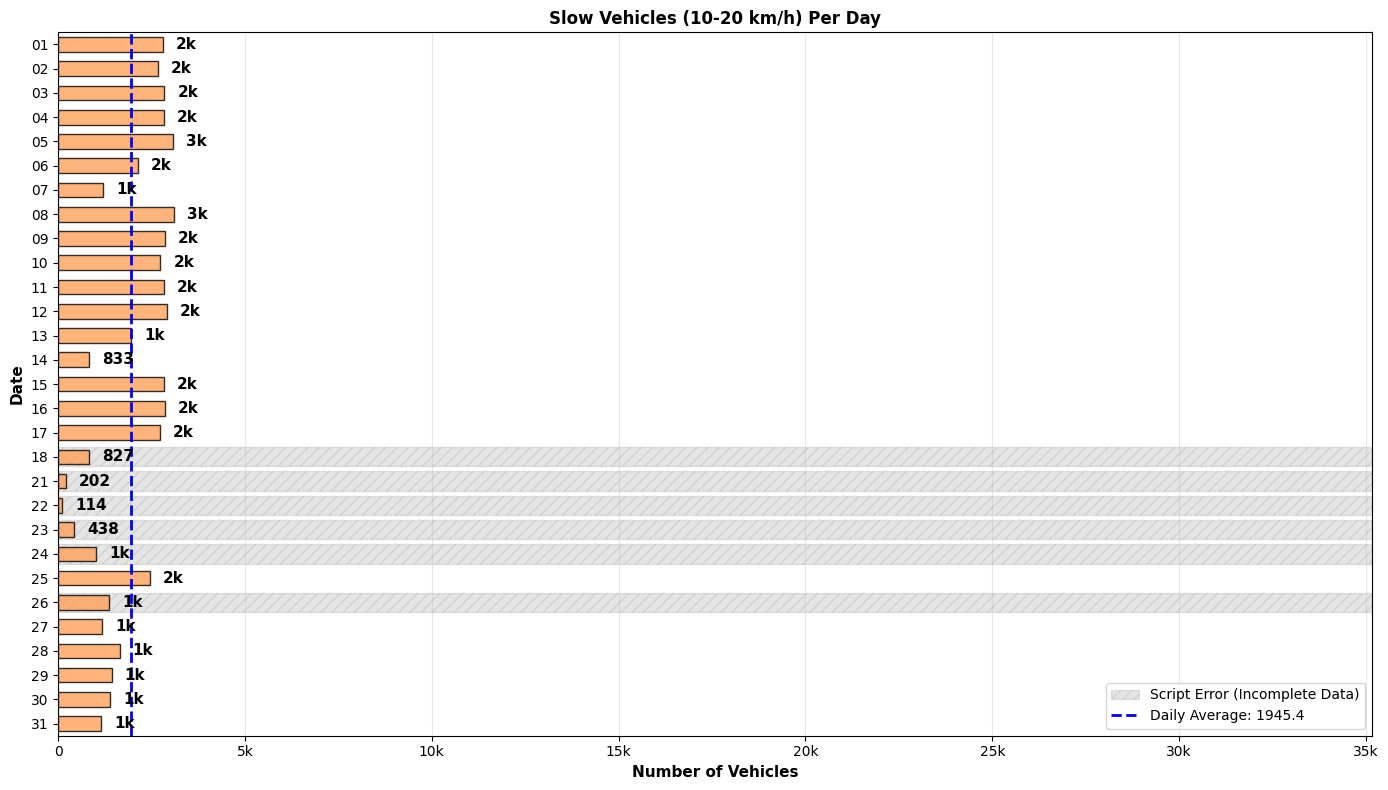

/Users/koi/Library/Mobile Documents/com~apple~CloudDocs/Fiorenzo Luethi/Istruzione/FHNW/Secondo Semestre/cde1 1db - Vision-based Traffic Monitoring/Traffic-Challenge-Wrang/Traffic-monitoring-Challenge/utils/plots_fiorenzo.py:161: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patch = ax.axhspan(i - 0.4, i + 0.4, alpha=0.2, color='gray',


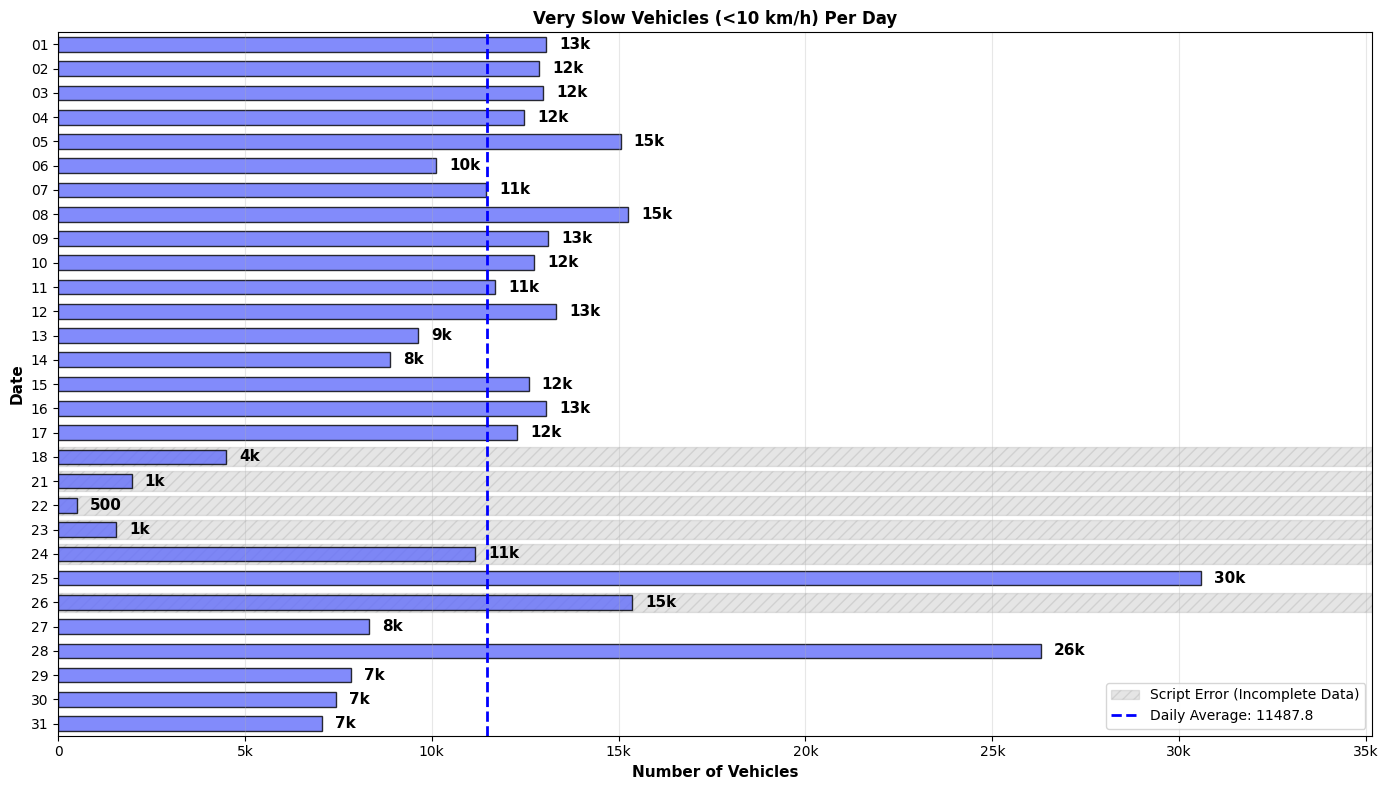

VEHICLE SPEED CATEGORY STATISTICS

Data collection period: 2025-12-31 to 2025-12-01
Total days: 29
Total vehicles: 489601

Speeding (>20 km/h):
  Total: 100038 (20.4%)
  Daily average: 3449.6
  Maximum: 5360 (on 2025-12-12)
  Minimum: 341 (on 2025-12-21)

Slow (10-20 km/h):
  Total: 56416 (11.5%)
  Daily average: 1945.4
  Maximum: 3105 (on 2025-12-08)
  Minimum: 114 (on 2025-12-22)

Very Slow (<10 km/h):
  Total: 333147 (68.0%)
  Daily average: 11487.8
  Maximum: 30580 (on 2025-12-25)
  Minimum: 500 (on 2025-12-22)



In [16]:
## Speeding vehicles histogram
from utils.plots_fiorenzo import speeding_vehicles_histogram
speeding_vehicles_histogram(final_summary, show_plot=True)  # Adjust speed limit as needed